# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

# Importing dataset

In [3]:
df = pd.read_csv("./insurance.txt")
df.drop(['children'], axis = 1, inplace = True)
df.head(10)

age     bmi      charges
0   19  27.900  16884.92400
1   18  33.770   1725.55230
2   28  33.000   4449.46200
3   33  22.705  21984.47061
4   32  28.880   3866.85520
5   31  25.740   3756.62160
6   46  33.440   8240.58960
7   37  27.740   7281.50560
8   37  29.830   6406.41070
9   60  25.840  28923.13692

# Shuffling and Preprocessing

In [4]:
df = df.sample(frac = 1)
df = df.reset_index(drop = True)
df.head(10)

age     bmi      charges
0   63  26.220  14256.19280
1   31  30.495   6113.23105
2   26  23.700   3484.33100
3   37  29.800  20420.60465
4   53  21.400  10065.41300
5   57  40.945  11566.30055
6   40  25.460   7077.18940
7   45  28.700   8027.96800
8   21  36.860   1917.31840
9   51  35.970   9386.16130

In [5]:
X = np.array(df.drop(['charges'], axis = 1))
X

array([[63.   , 26.22 ],
       [31.   , 30.495],
       [26.   , 23.7  ],
       ...,
       [64.   , 26.885],
       [23.   , 28.31 ],
       [34.   , 29.26 ]])

# Preprocessing and Generating coefficients array

In [6]:
polynomial_coefficients = []
for i in range(1, 11):
    poly = PolynomialFeatures(i)
    data = poly.fit_transform(X)
    polynomial_coefficients.append(np.array(data))

In [7]:
def standardise(x, mean, std):
    return (x-mean)/std

In [8]:
def standardising_columns(df):
    for i,column in enumerate(df.T):
        mn = column.mean()
        stdev = column.std()
        column = standardise(column, mn, stdev)
        df[:, i] = column
    df[:, 0] =  1 # bias term
    return df

In [9]:
for i in range(10):
    polynomial_coefficients[i] = standardising_columns(polynomial_coefficients[i])

<ipython-input-7-384af29ed020>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x-mean)/std


## Standardising target

In [10]:
target_mean = df.mean()['charges']
target_variance = df.std()['charges']
df['charges']  = df['charges'].apply(lambda x : standardise(x,target_mean,target_variance)) 
y = np.array((df['charges'])).reshape(len(df), 1)

In [11]:
train_set_size = int(0.7 * len(df)) # 70% training
val_set_size = int(0.2 * len(df)) # 20% validation
y_train = y[ : train_set_size]
y_val =  y[train_set_size : train_set_size+val_set_size]
y_test = y[train_set_size+val_set_size : ]

# Useful tools

In [12]:
def loss_function(w,X,y):
    return (0.5) * (np.sum((np.dot(X,w) - y)**2))

In [13]:
def grad_descent(w,X,y,eta,print_flag,reg,l_value,epochs=10000):
    loss_values = []
    for i in range(epochs):
        if print_flag == True:
            if i%1000 == 0:
                print(loss_function(w,X,y))
        if i%50 == 0:
            loss_values.append(loss_function(w,X,y))
        A = X.transpose()
        B = X.dot(w) - y
        if reg == "l1":
            dw = A.dot(B) + l_value*np.sign(w)
            dw[0] = dw[0] - l_value*np.sign(w[0])
        elif reg == "l2":
            dw = A.dot(B) + l_value*2*w
            dw[0] = dw[0] - l_value*2*w[0]
        elif reg == "simple":
            dw = A.dot(B)
        w = w - (eta*dw)/len(X)
    return w,loss_values

In [14]:
def prediction(parameters,X_test):
    return np.dot(X_test,parameters)

In [15]:
def RMSE(y_true,y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

# Polynomial regression w/o regularization

In [16]:
weights_wo_regu = []
train_errors = []
val_errors = []
test_errors = []
train_RMSE = []
val_RMSE = []
test_RMSE = []

# For each degree
for i in range(10):
    w = np.zeros((polynomial_coefficients[i].shape[1],1))
    X_train = polynomial_coefficients[i][:train_set_size]
    X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
    X_test = polynomial_coefficients[i][train_set_size + val_set_size:]
    print("Polynomial Degree =", (i+1))
    print("Training error every 1,000 iterations: ")
    weights,error = grad_descent(w,X_train,y_train,0.01,print_flag = True,reg = "simple",l_value = 0)
    # Appending errors
    train_errors.append(loss_function(weights,X_train,y_train))
    val_errors.append(loss_function(weights,X_val,y_val))
    test_errors.append(loss_function(weights,X_test,y_test))
    # Predictions
    y_train_pred = prediction(weights,X_train)
    y_val_pred = prediction(weights,X_val)
    y_test_pred = prediction(weights,X_test)
    # RMSE values
    train_RMSE.append(RMSE(y_train,y_train_pred))
    val_RMSE.append(RMSE(y_val,y_val_pred))
    test_RMSE.append(RMSE(y_test,y_test_pred))
    print("")
    weights_wo_regu.append(weights)

Polynomial Degree = 1
Training error every 1,000 iterations: 
473.3774344042984
418.4825687760067
418.4825687042673
418.48256870426735
418.48256870426735
418.48256870426735
418.48256870426735
418.48256870426735
418.48256870426735
418.48256870426735

Polynomial Degree = 2
Training error every 1,000 iterations: 
473.3774344042984
417.8996377860907
417.5339523488385
417.25591334204455
417.0416451229271
416.8744799424771
416.74262955725976
416.6376388152164
416.55335312632553
416.4852246059428

Polynomial Degree = 3
Training error every 1,000 iterations: 
473.3774344042984
417.06777428448373
416.40162576996136
416.11152439773167
415.9751718361939
415.9069005110322
415.8701522059059
415.84834743842924
415.8337225491987
415.82258403040726

Polynomial Degree = 4
Training error every 1,000 iterations: 
473.3774344042984
416.078252833237
415.6164095432783
415.5133314900972
415.46386065816245
415.424359996759
415.38802117581423
415.3536597831373
415.32098331030755
415.2898493130411

Polynomial D

In [17]:
for i in range(10):
    print("For model with degree {}:".format(i+1))
    print("Train SSE = {}".format(train_errors[i]))
    print("Validation SSE = {}".format(val_errors[i]))
    print("Test SSE = {}".format(test_errors[i]))
    print("Train RMSE = {}".format(train_RMSE[i]))
    print("Validation RMSE = {}".format(val_RMSE[i]))
    print("Test RMSE = {}".format(test_RMSE[i]))
    print(" ")

For model with degree 1:
Train SSE = 418.48256870426735
Validation SSE = 110.84574008239998
Test SSE = 60.91455471255742
Train RMSE = 0.9456180639520197
Validation RMSE = 0.9112108258556602
Test RMSE = 0.9499672876438658
 
For model with degree 2:
Train SSE = 416.4298422116535
Validation SSE = 111.50798212535743
Test SSE = 61.79287171469797
Train RMSE = 0.9432960061153157
Validation RMSE = 0.9139287629298809
Test RMSE = 0.956791487905729
 
For model with degree 3:
Train SSE = 415.81316111964645
Validation SSE = 112.16093157624735
Test SSE = 62.40490620421411
Train RMSE = 0.9425972949844833
Validation RMSE = 0.9166006714122097
Test RMSE = 0.961518137609125
 
For model with degree 4:
Train SSE = 415.2601467230955
Validation SSE = 112.22368296771327
Test SSE = 62.80738385271623
Train RMSE = 0.9419702786280362
Validation RMSE = 0.9168570437693451
Test RMSE = 0.9646137884049664
 
For model with degree 5:
Train SSE = 414.6144192190976
Validation SSE = 112.1615364997621
Test SSE = 63.46665358

# Printing plots

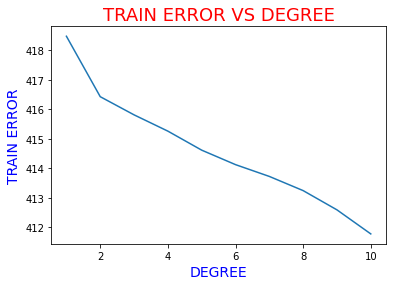

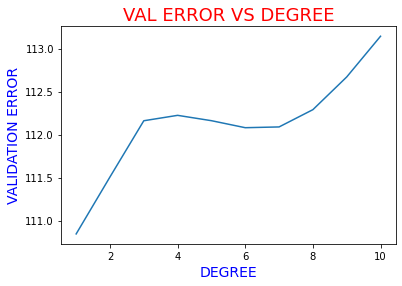

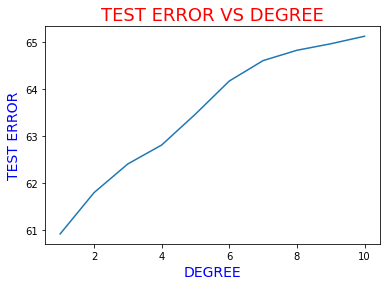

In [18]:
x = [1,2,3,4,5,6,7,8,9,10]
# Train error plot
plt.subplot()
plt.plot(x,train_errors)
plt.xlabel("DEGREE",color = 'blue',fontsize = 14)
plt.ylabel("TRAIN ERROR",color = 'blue',fontsize = 14)
plt.title("TRAIN ERROR VS DEGREE",fontsize = 18,color = 'red')
plt.show()
# Validation error plot
plt.subplot()
plt.plot(x,val_errors)
plt.xlabel("DEGREE",color = 'blue',fontsize = 14)
plt.ylabel("VALIDATION ERROR",color = 'blue',fontsize = 14)
plt.title("VAL ERROR VS DEGREE",fontsize = 18,color = 'red')
plt.show()
# Test error plot
plt.subplot()
plt.plot(x,test_errors)
plt.xlabel("DEGREE",color = 'blue',fontsize = 14)
plt.ylabel("TEST ERROR",color = 'blue',fontsize = 14)
plt.title("TEST ERROR VS DEGREE",fontsize = 18,color = 'red')
plt.show()

# Generating lambda values

In [19]:
# random.seed(69)
# hyperparams = np.random.uniform(0,1,10)
# hyperparams.sort() # to generate the below hyperparameters
# print(hyperparams)
lambda_values = [0.12936004, 0.33442952, 0.33670087, 0.4250879,  0.44624685, 0.47690573, 0.66371102,
               0.73128514, 0.80157154, 0.94589127]

# Finding best lambda values for lasso regression

In [20]:
optimal_lambdas = []
for i in range(10):
    error_val = []
    for lam in lambda_values:
        w = np.zeros((polynomial_coefficients[i].shape[1],1))
        X_train = polynomial_coefficients[i][:train_set_size]
        X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
        weights,error = grad_descent(w,X_train,y_train,0.01,print_flag = False,reg = "l1",l_value = lam)
        print("Validation error for degree {} and hyperparameter {} is {}".format(i+1,lam,loss_function(weights,X_val,y_val)))
        error_val.append(loss_function(weights,X_val,y_val))
        print("")
    error_val = np.array(error_val)
    indices = np.argsort(error_val)
    optimal_lambdas.append(lambda_values[indices[0]])

Validation error for degree 1 and hyperparameter 0.12936004 is 110.84643960328299

Validation error for degree 1 and hyperparameter 0.33442952 is 110.8475657055257

Validation error for degree 1 and hyperparameter 0.33670087 is 110.84757829620219

Validation error for degree 1 and hyperparameter 0.4250879 is 110.84807025537883

Validation error for degree 1 and hyperparameter 0.44624685 is 110.84818860596883

Validation error for degree 1 and hyperparameter 0.47690573 is 110.84836049146492

Validation error for degree 1 and hyperparameter 0.66371102 is 110.84941796959049

Validation error for degree 1 and hyperparameter 0.73128514 is 110.84980480280578

Validation error for degree 1 and hyperparameter 0.80157154 is 110.85020958983216

Validation error for degree 1 and hyperparameter 0.94589127 is 110.85104850094635

Validation error for degree 2 and hyperparameter 0.12936004 is 111.49247885137504

Validation error for degree 2 and hyperparameter 0.33442952 is 111.46678371062896

Valida

Validation error for degree 10 and hyperparameter 0.94589127 is 112.47381016370976



In [21]:
optimal_lambdas

[0.12936004,
 0.94589127,
 0.94589127,
 0.12936004,
 0.12936004,
 0.33442952,
 0.47690573,
 0.94589127,
 0.94589127,
 0.94589127]

# Polynomial Regression with L1 Regularization (using optimal lambdas)

In [22]:
weights_w_lasso = []
train_errors = []
val_errors = []
test_errors = []
train_RMSE = []
val_RMSE = []
test_RMSE = []

for i in range(10):
    w = np.zeros((polynomial_coefficients[i].shape[1],1))
    X_train = polynomial_coefficients[i][:train_set_size]
    X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
    X_test = polynomial_coefficients[i][train_set_size + val_set_size:]
    print("Lasso regularization model with degree {} and lambda as {}".format(i+1,optimal_lambdas[i]))
    print("Training error every 1000 iterations:")
    weights,error = grad_descent(w,X_train,y_train,0.01,print_flag = True,reg = "l1",l_value = optimal_lambdas[i])

    train_errors.append(loss_function(weights,X_train,y_train))
    val_errors.append(loss_function(weights,X_val,y_val))
    test_errors.append(loss_function(weights,X_test,y_test))

    y_train_pred = prediction(weights,X_train)
    y_val_pred = prediction(weights,X_val)
    y_test_pred = prediction(weights,X_test)

    train_RMSE.append(RMSE(y_train,y_train_pred))
    val_RMSE.append(RMSE(y_val,y_val_pred))
    test_RMSE.append(RMSE(y_test,y_test_pred))
    print("")
    weights_w_lasso.append(weights)

Lasso regularization model with degree 1 and lambda as 0.12936004
Training error every 1000 iterations:
473.3774344042984
418.48258529419456
418.48258449913783
418.4825844991193
418.48258449911924
418.48258449911924
418.48258449911924
418.48258449911924
418.48258449911924
418.48258449911924

Lasso regularization model with degree 2 and lambda as 0.94589127
Training error every 1000 iterations:
473.3774344042984
417.9072790788672
417.5444634087355
417.2846694569455
417.1063314921446
416.96882120066107
416.86783612958857
416.79199360806103
416.74270113422915
416.69980394292895

Lasso regularization model with degree 3 and lambda as 0.94589127
Training error every 1000 iterations:
473.3774344042984
417.13458753226234
416.5379521478473
416.25015184582577
416.098330838788
416.0122418326529
415.9600046514531
415.9258855254944
415.90000850169906
415.88670556448085

Lasso regularization model with degree 4 and lambda as 0.12936004
Training error every 1000 iterations:
473.3774344042984
416.093

In [23]:
for i in range(10):
    print("FOR MODEL WITH DEGREE {} AND LAMBDA {}:".format(i+1,optimal_lambdas[i]))
    print("Train SSE = {}".format(train_errors[i]))
    print("Validation SSE = {}".format(val_errors[i]))
    print("Test SSE = {}".format(test_errors[i]))
    print("Train RMSE = {}".format(train_RMSE[i]))
    print("Validation RMSE = {}".format(val_RMSE[i]))
    print("Test RMSE = {}".format(test_RMSE[i]))
    print(" ")

FOR MODEL WITH DEGREE 1 AND LAMBDA 0.12936004:
Train SSE = 418.48258449911924
Validation SSE = 110.84643960328299
Test SSE = 60.91394480791836
Train RMSE = 0.9456180817973235
Validation RMSE = 0.9112137010676232
Test RMSE = 0.9499625318764741
 
FOR MODEL WITH DEGREE 2 AND LAMBDA 0.94589127:
Train SSE = 416.6623758758787
Validation SSE = 111.38485358147983
Test SSE = 61.624084664297285
Train RMSE = 0.9435593367441211
Validation RMSE = 0.9134240376300856
Test RMSE = 0.9554838577569136
 
FOR MODEL WITH DEGREE 3 AND LAMBDA 0.94589127:
Train SSE = 415.878520339801
Validation SSE = 112.1024646684634
Test SSE = 62.29283299928537
Train RMSE = 0.9426713727303841
Validation RMSE = 0.9163617388716591
Test RMSE = 0.9606543526027445
 
FOR MODEL WITH DEGREE 4 AND LAMBDA 0.12936004:
Train SSE = 415.28084257484903
Validation SSE = 112.24189987469417
Test SSE = 62.79989906278587
Train RMSE = 0.9419937514251548
Validation RMSE = 0.9169314559668729
Test RMSE = 0.9645563099188326
 
FOR MODEL WITH DEGREE 5

# Polynomial Regression with ridge regularization

## Finding optimal lambda values

In [24]:
optimal_lambdas = []
for i in range(10):
    error_val = []
    for lam in lambda_values:
        w = np.zeros((polynomial_coefficients[i].shape[1],1))
        X_train = polynomial_coefficients[i][:train_set_size]
        X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
        weights,error = grad_descent(w,X_train,y_train,0.01, print_flag = False, reg = "l2", l_value = lam)
        print("Validation error for degree {} and hyperparameter {} is {}".format(i+1,lam,loss_function(weights,X_val,y_val)))
        error_val.append(loss_function(weights,X_val,y_val))
        print("")
    error_val = np.array(error_val)
    indices = np.argsort(error_val)
    optimal_lambdas.append(lambda_values[indices[0]])

Validation error for degree 1 and hyperparameter 0.12936004 is 110.84597179264615

Validation error for degree 1 and hyperparameter 0.33442952 is 110.84634265179731

Validation error for degree 1 and hyperparameter 0.33670087 is 110.84634678369545

Validation error for degree 1 and hyperparameter 0.4250879 is 110.84650798417715

Validation error for degree 1 and hyperparameter 0.44624685 is 110.84654669313616

Validation error for degree 1 and hyperparameter 0.47690573 is 110.84660286327914

Validation error for degree 1 and hyperparameter 0.66371102 is 110.84694719550215

Validation error for degree 1 and hyperparameter 0.73128514 is 110.84707263446738

Validation error for degree 1 and hyperparameter 0.80157154 is 110.84720360467968

Validation error for degree 1 and hyperparameter 0.94589127 is 110.84747411192825

Validation error for degree 2 and hyperparameter 0.12936004 is 111.50042806512741

Validation error for degree 2 and hyperparameter 0.33442952 is 111.48884599394626

Valid

Validation error for degree 10 and hyperparameter 0.94589127 is 113.0659255718528



In [25]:
optimal_lambdas

[0.12936004,
 0.94589127,
 0.94589127,
 0.94589127,
 0.94589127,
 0.12936004,
 0.94589127,
 0.94589127,
 0.94589127,
 0.94589127]

# Polynomial Regression with L2 Regularization (using optimal lambdas)

In [26]:
weights_w_ridge = []
train_errors = []
val_errors = []
test_errors = []
train_RMSE = []
val_RMSE = []
test_RMSE = []

for i in range(10):
    w = np.zeros((polynomial_coefficients[i].shape[1],1))
    X_train = polynomial_coefficients[i][:train_set_size]
    X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
    X_test = polynomial_coefficients[i][train_set_size + val_set_size:]
    print("Ridge regularization model with degree {} and lambda as {}".format(i+1,optimal_lambdas[i]))
    print("Training error every 1000 iterations:")
    weights,error = grad_descent(w,X_train,y_train,0.01, print_flag = True, reg = "l2", l_value = optimal_lambdas[i])

    train_errors.append(loss_function(weights,X_train,y_train))
    val_errors.append(loss_function(weights,X_val,y_val))
    test_errors.append(loss_function(weights,X_test,y_test))

    y_train_pred = prediction(weights,X_train)
    y_val_pred = prediction(weights,X_val)
    y_test_pred = prediction(weights,X_test)

    train_RMSE.append(RMSE(y_train,y_train_pred))
    val_RMSE.append(RMSE(y_val,y_val_pred))
    test_RMSE.append(RMSE(y_test,y_test_pred))
    print("")
    weights_w_ridge.append(weights)

Ridge regularization model with degree 1 and lambda as 0.12936004
Training error every 1000 iterations:
473.3774344042984
418.4825726851719
418.4825720723909
418.48257207234656
418.48257207234656
418.48257207234656
418.48257207234656
418.48257207234656
418.48257207234656
418.48257207234656

Ridge regularization model with degree 2 and lambda as 0.94589127
Training error every 1000 iterations:
473.3774344042984
417.9040857663162
417.5479193058858
417.2809534494522
417.077548075896
416.92022459856935
416.796884831895
416.69901828822276
416.6205378542954
416.5570167915613

Ridge regularization model with degree 3 and lambda as 0.94589127
Training error every 1000 iterations:
473.3774344042984
417.0797138501806
416.4246795860712
416.1386910611601
416.0021423256453
415.9318089473047
415.89259481826207
415.86865579667165
415.8525208584166
415.8405508117416

Ridge regularization model with degree 4 and lambda as 0.94589127
Training error every 1000 iterations:
473.3774344042984
416.0929435135

In [27]:
for i in range(10):
    print("FOR MODEL WITH DEGREE {} AND LAMBDA {}:".format(i+1,optimal_lambdas[i]))
    print("Train SSE = {}".format(train_errors[i]))
    print("Validation SSE = {}".format(val_errors[i]))
    print("Test SSE = {}".format(test_errors[i]))
    print("Train RMSE = {}".format(train_RMSE[i]))
    print("Validation RMSE = {}".format(val_RMSE[i]))
    print("Test RMSE = {}".format(test_RMSE[i]))
    print(" ")

FOR MODEL WITH DEGREE 1 AND LAMBDA 0.12936004:
Train SSE = 418.48257207234656
Validation SSE = 110.84597179264615
Test SSE = 60.91465909007342
Train RMSE = 0.9456180677573355
Validation RMSE = 0.9112117782457758
Test RMSE = 0.9499681015313165
 
FOR MODEL WITH DEGREE 2 AND LAMBDA 0.94589127:
Train SSE = 416.505183492079
Validation SSE = 111.4569804746919
Test SSE = 61.72305588051542
Train RMSE = 0.9433813337113686
Validation RMSE = 0.9137197321247346
Test RMSE = 0.9562508262345725
 
FOR MODEL WITH DEGREE 3 AND LAMBDA 0.94589127:
Train SSE = 415.8309186743952
Validation SSE = 112.10197649345675
Test SSE = 62.3319120526552
Train RMSE = 0.942617421865901
Validation RMSE = 0.9163597436194302
Test RMSE = 0.96095563587161
 
FOR MODEL WITH DEGREE 4 AND LAMBDA 0.94589127:
Train SSE = 415.2917935153922
Validation SSE = 112.20317471127854
Test SSE = 62.74413016023415
Train RMSE = 0.9420061715135636
Validation RMSE = 0.916773264668574
Test RMSE = 0.964127931884823
 
FOR MODEL WITH DEGREE 5 AND LAM

## Weights for Degree 2 Polynomial (for example)

In [28]:
print("For model of degree 2 and no regularization the weights are {}".format(weights_wo_regu[1]))
print("For model of degree 2 and Lasso regularization the weights are {}".format(weights_w_lasso[1]))
print("For model of degree 2 and Ridge regularization the weights are {}".format(weights_w_ridge[1]))

For model of degree 2 and no regularization the weights are [[ 0.00183887]
 [-0.02048458]
 [ 0.31471791]
 [ 0.31912408]
 [-0.02658443]
 [-0.13007134]]
For model of degree 2 and Lasso regularization the weights are [[ 0.00170434]
 [-0.00434926]
 [ 0.25436273]
 [ 0.28476434]
 [-0.00413211]
 [-0.0799129 ]]
For model of degree 2 and Ridge regularization the weights are [[ 0.00178432]
 [-0.0113173 ]
 [ 0.29467841]
 [ 0.30320638]
 [-0.01863834]
 [-0.11378985]]


# 3D surface plots

### Without regularization

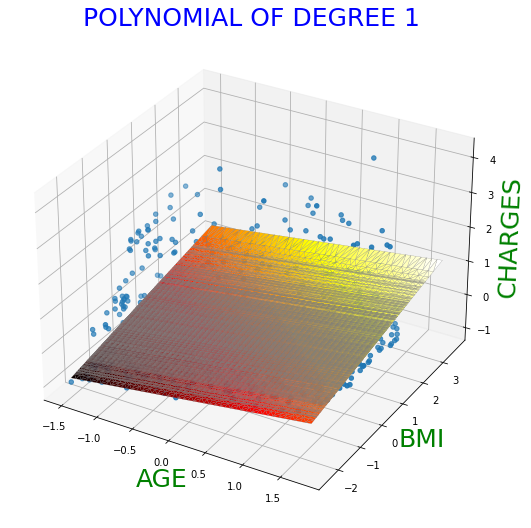

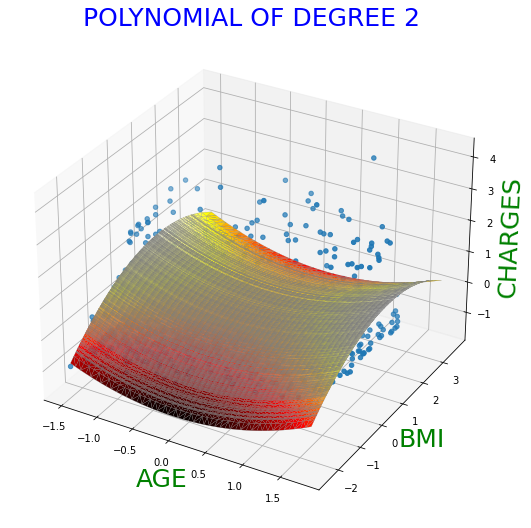

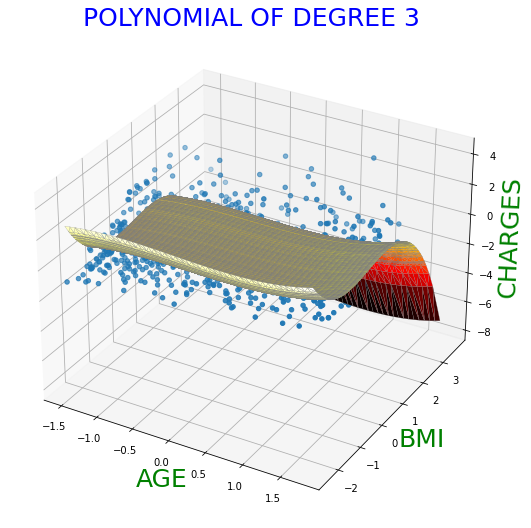

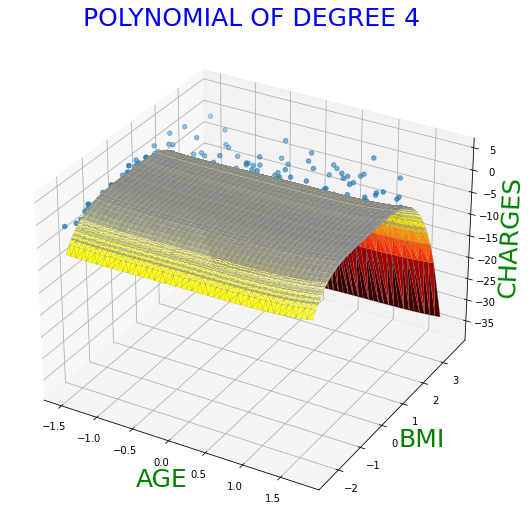

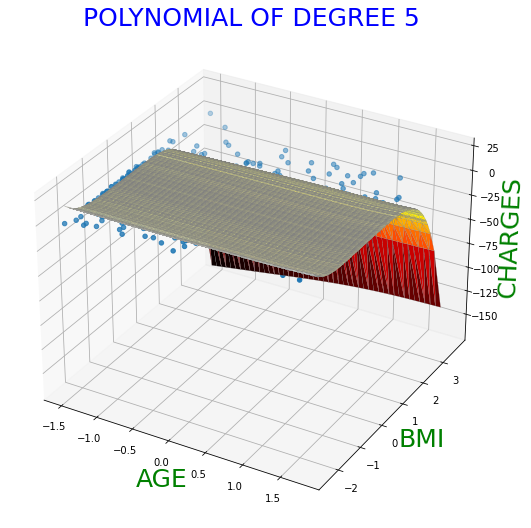

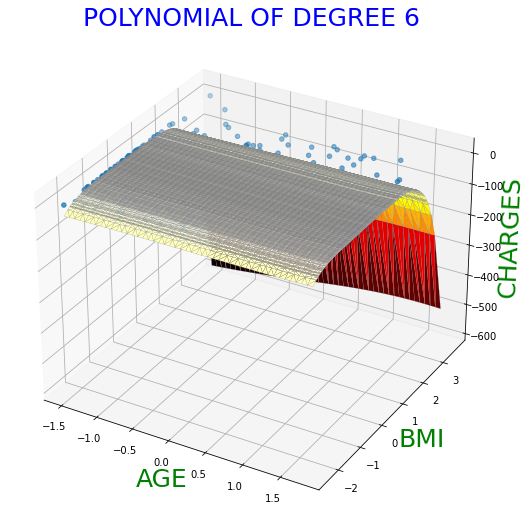

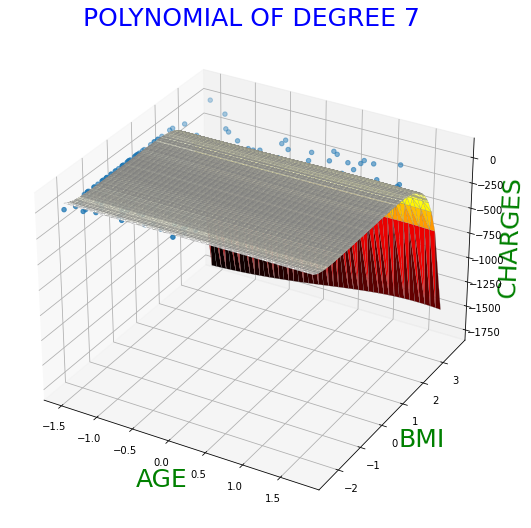

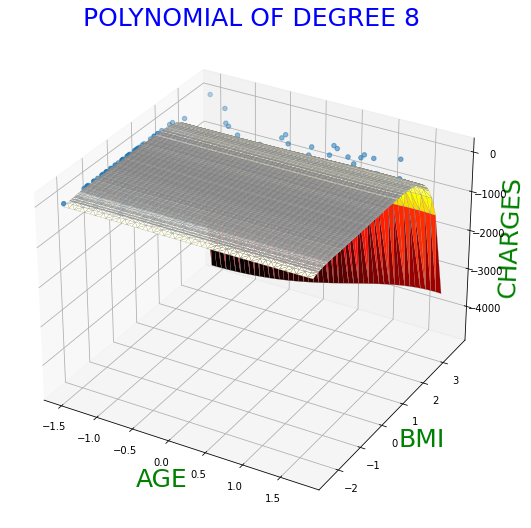

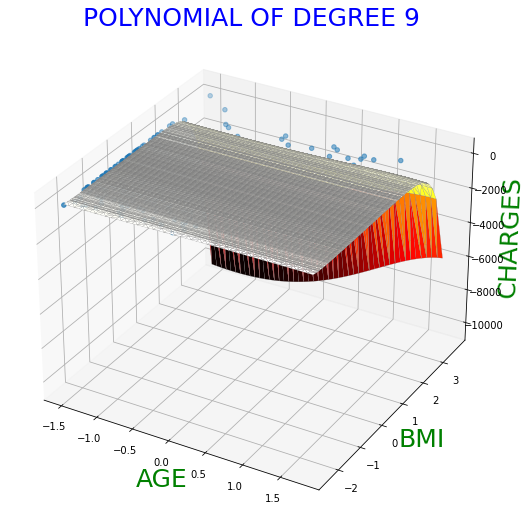

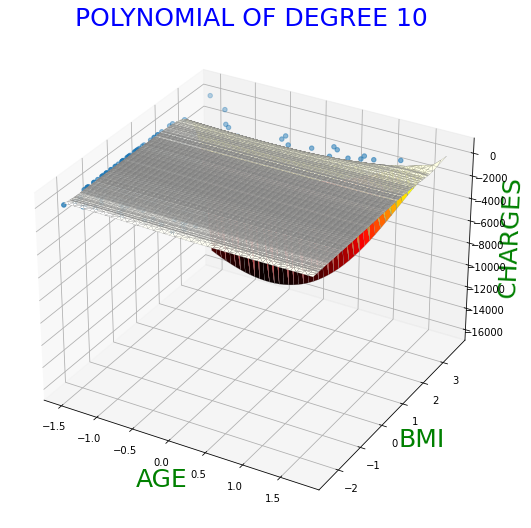

In [29]:
from mpl_toolkits.mplot3d import Axes3D
for i in range(10):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    X = X_train[:][:,1]
    Y = X_train[:][:,2]
    X,Y = np.meshgrid(X, Y)
    X = X.flatten()
    Y = Y.flatten()
    matr = np.array(np.vstack((X, Y)).T,dtype = 'float')
    poly = PolynomialFeatures(i+1)
    data = poly.fit_transform(matr)
    z = prediction(weights_wo_regu[i],data)
    ax.set_title('POLYNOMIAL OF DEGREE {}'.format(i+1),fontsize=25, color = "Blue")
    ax.set_xlabel('AGE', fontsize=25, color = "green",y=5)
    ax.set_ylabel('BMI',color = "green",fontsize = 25,y=5)
    ax.set_zlabel('CHARGES', fontsize=25,color = "green",y=5)
    my_cmap = plt.get_cmap('hot') 
    ax.scatter(X_train[:][:,1],X_train[:][:,2],y_train, zdir='z', s=20, c=None, depthshade=True,cmap = my_cmap)
    trisurf = ax.plot_trisurf(X, Y, z.flatten(), cmap = my_cmap,linewidth = 0.2,antialiased = True,edgecolor = 'grey') 
    plt.show()

### With lasso regularization

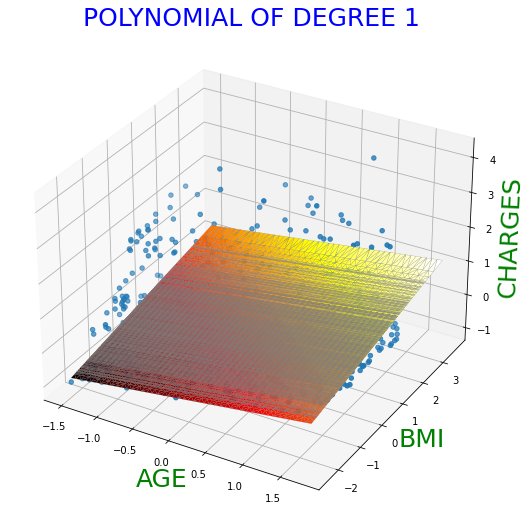

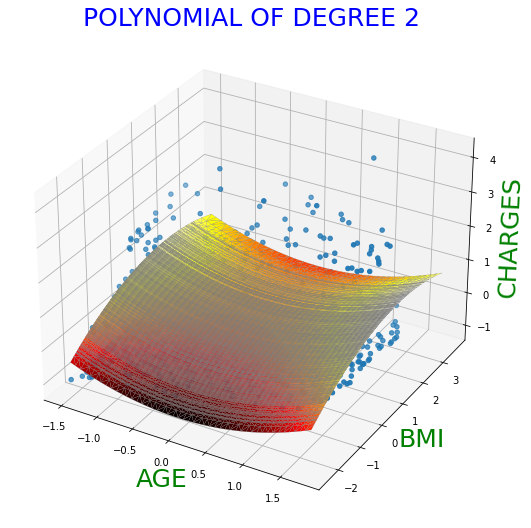

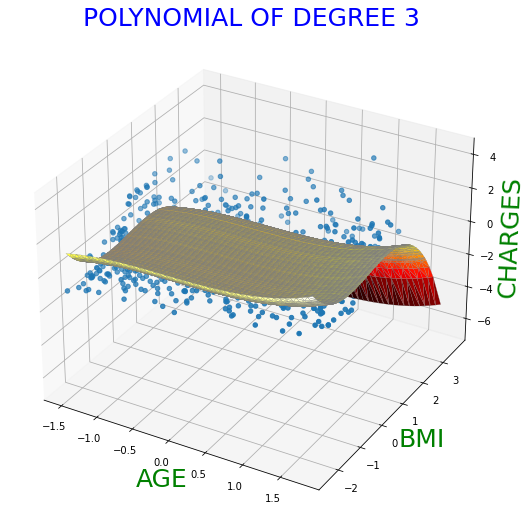

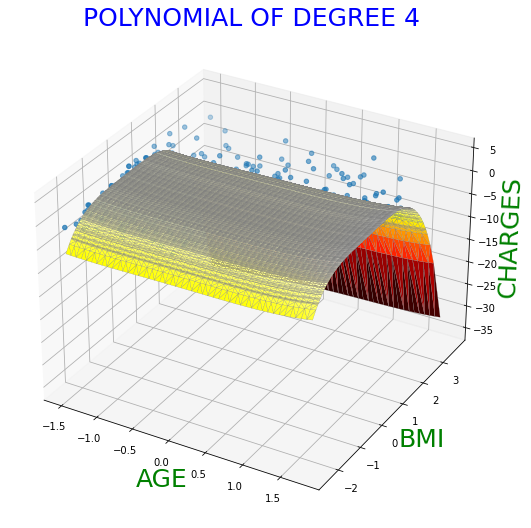

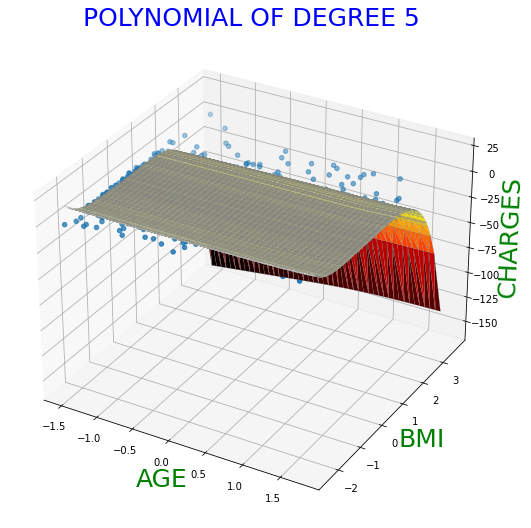

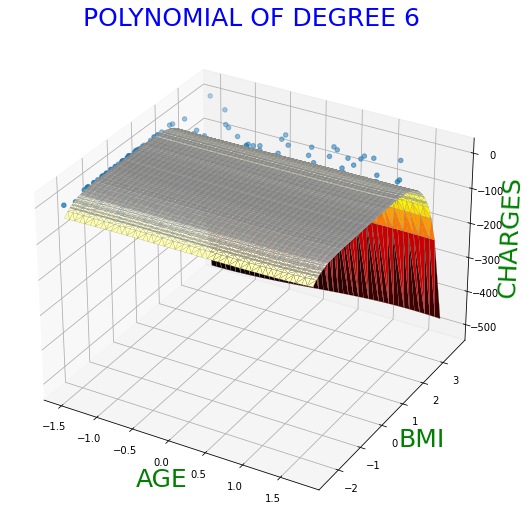

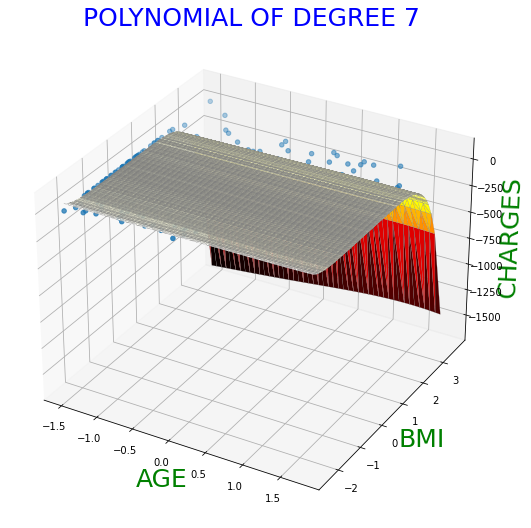

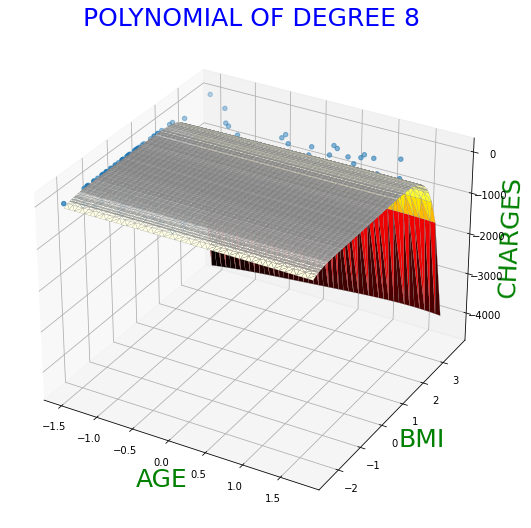

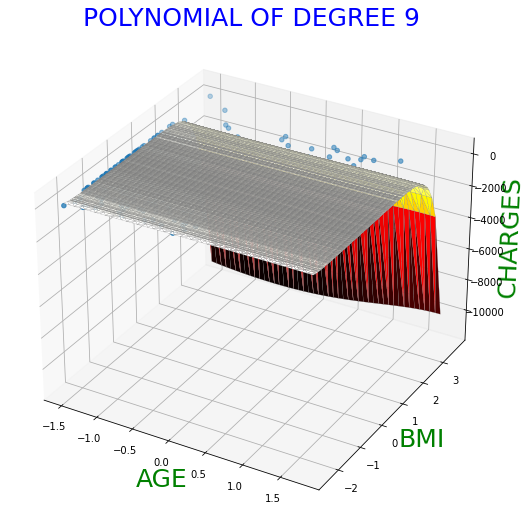

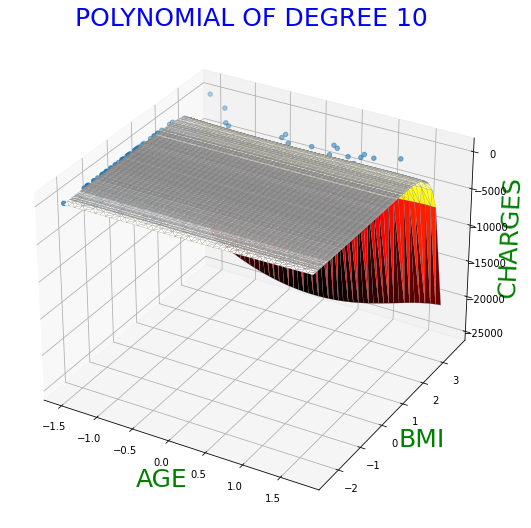

In [30]:
for i in range(10):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    X = X_train[:][:,1]
    Y = X_train[:][:,2]
    X,Y = np.meshgrid(X, Y)
    X = X.flatten()
    Y = Y.flatten()
    matr = np.array(np.vstack((X, Y)).T,dtype = 'float')
    poly = PolynomialFeatures(i+1)
    data = poly.fit_transform(matr)
    z = prediction(weights_w_lasso[i],data)
    ax.set_title('POLYNOMIAL OF DEGREE {}'.format(i+1),fontsize=25, color = "Blue")
    ax.set_xlabel('AGE', fontsize=25, color = "green",y=5)
    ax.set_ylabel('BMI',color = "green",fontsize = 25,y=5)
    ax.set_zlabel('CHARGES', fontsize=25,color = "green",y=5)
    my_cmap = plt.get_cmap('hot') 
    ax.scatter(X_train[:][:,1],X_train[:][:,2],y_train, zdir='z', s=20, c=None, depthshade=True,cmap = my_cmap)
    trisurf = ax.plot_trisurf(X, Y, z.flatten(), cmap = my_cmap,linewidth = 0.2,antialiased = True,edgecolor = 'grey') 
    plt.show()

### With ridge regularization

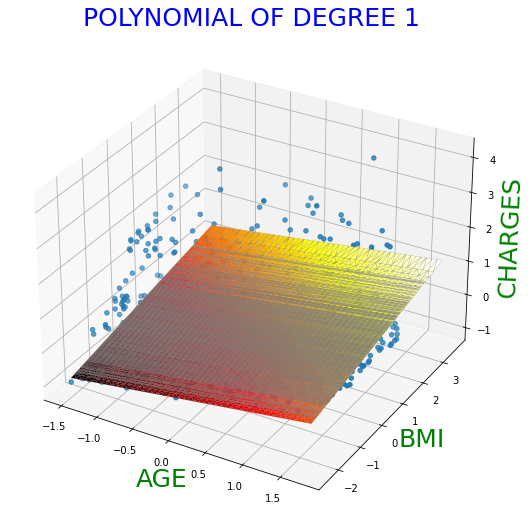

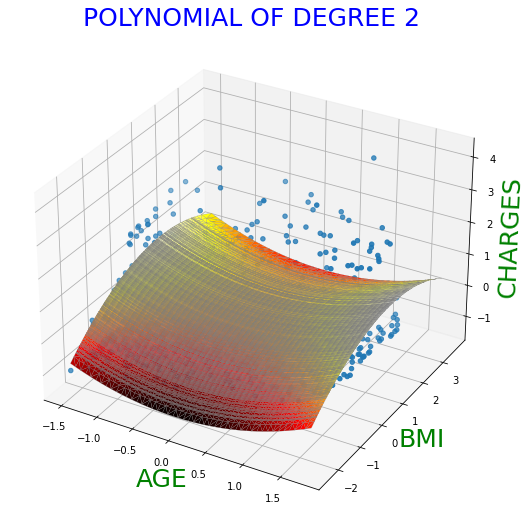

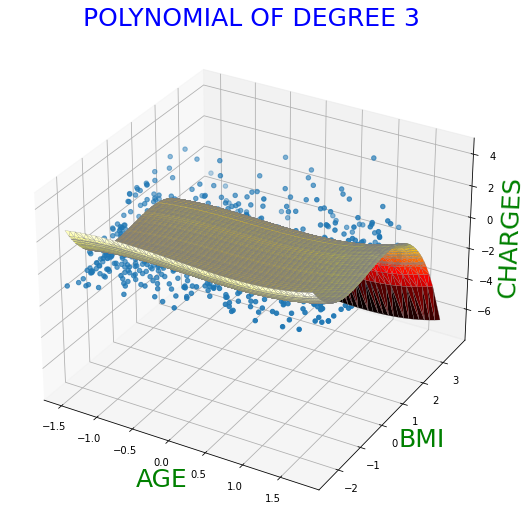

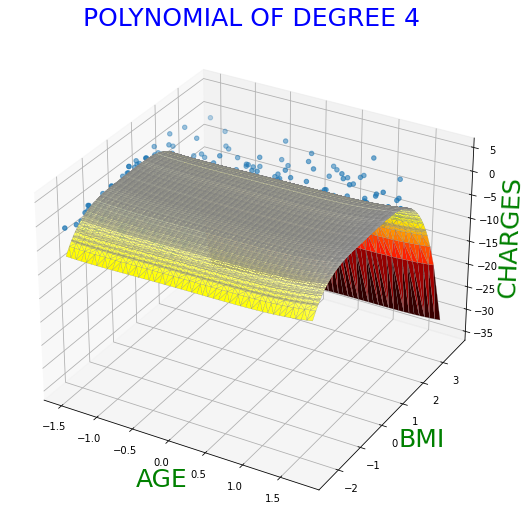

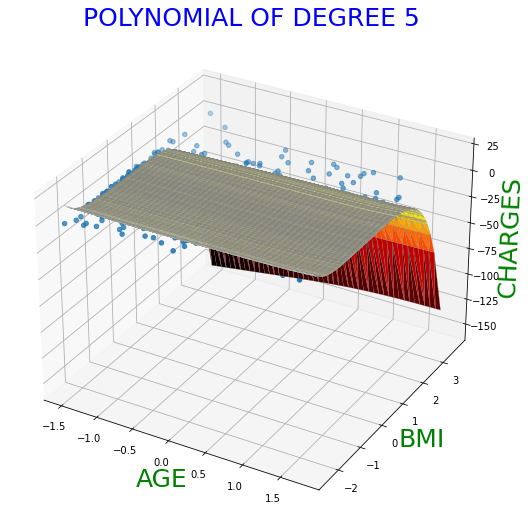

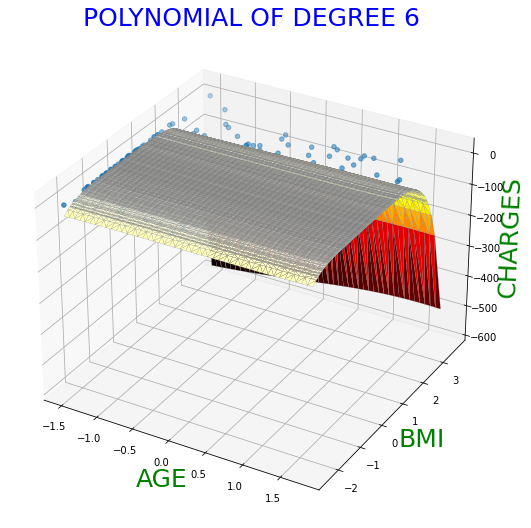

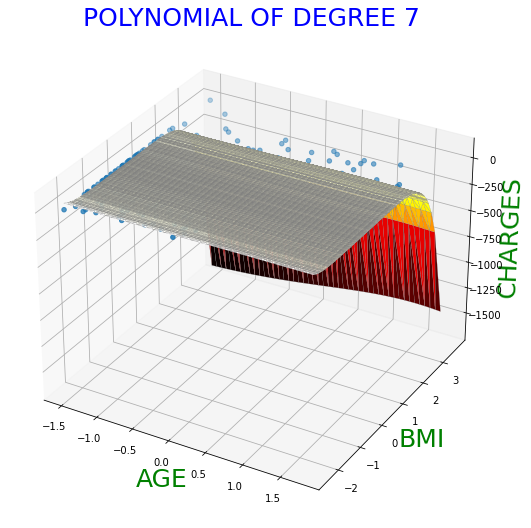

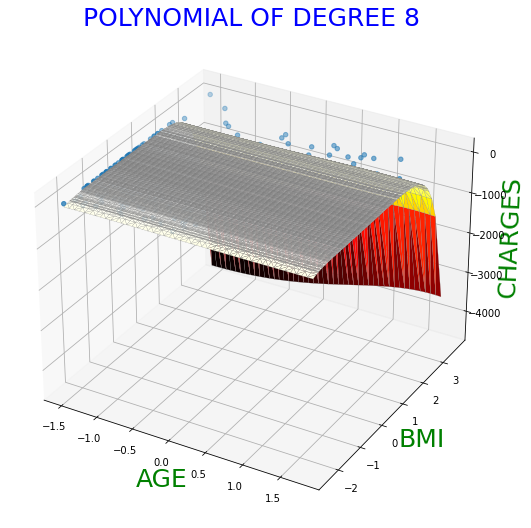

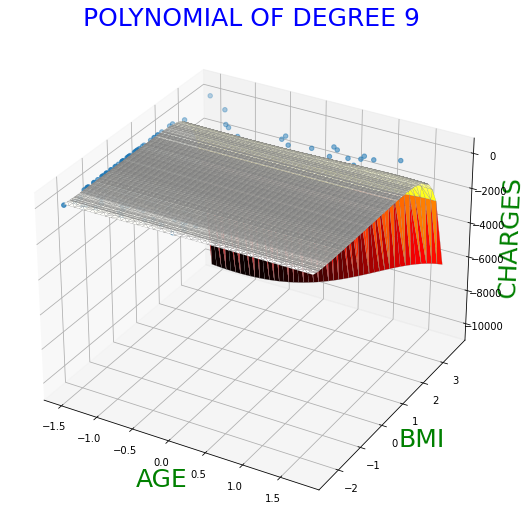

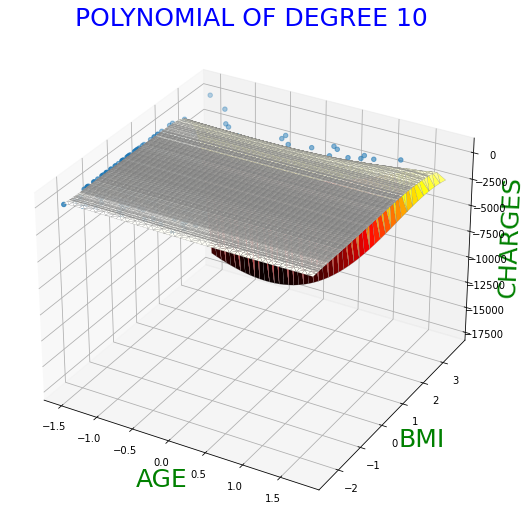

In [31]:
for i in range(10):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    X = X_train[:][:,1]
    Y = X_train[:][:,2]
    X,Y = np.meshgrid(X, Y)
    X = X.flatten()
    Y = Y.flatten()
    matr = np.array(np.vstack((X, Y)).T,dtype = 'float')
    poly = PolynomialFeatures(i+1)
    data = poly.fit_transform(matr)
    z = prediction(weights_w_ridge[i],data)
    ax.set_title('POLYNOMIAL OF DEGREE {}'.format(i+1),fontsize=25, color = "Blue")
    ax.set_xlabel('AGE', fontsize=25, color = "green",y=5)
    ax.set_ylabel('BMI',color = "green",fontsize = 25,y=5)
    ax.set_zlabel('CHARGES', fontsize=25,color = "green",y=5)
    my_cmap = plt.get_cmap('hot') 
    ax.scatter(X_train[:][:,1],X_train[:][:,2],y_train, zdir='z', s=20, c=None, depthshade=True,cmap = my_cmap)
    trisurf = ax.plot_trisurf(X, Y, z.flatten(), cmap = my_cmap,linewidth = 0.2,antialiased = True,edgecolor = 'grey') 
    plt.show()